In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats

In [26]:
#phase_dir = '../phased_spark_del'
#ped_file = '../../DATA/spark/spark.ped'
#identicals_file = '../sibpair_similarity/spark_identicals.txt'

#phase_dir = '../phased_mssng_quads_del'
#ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
#identicals_file = '../sibpair_similarity/mssng_quads_identicals.txt'

phase_dir = '../phased_ssc.hg38_del'
ped_file = '../../DATA/ssc.hg38/ssc.ped'
identicals_file = '../sibpair_similarity/ssc.hg38_identicals.txt'

build = '38'

chroms = [str(x) for x in range(1, 23)]
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']

In [4]:
with open('%s/deletions.json' % phase_dir, 'r') as f:
    deletions = json.load(f)
                          
print(len(deletions))                      

532131


In [12]:
# pull identical pairs
identical_pairs = set()
with open(identicals_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        identical_pairs.add((pieces[0], pieces[1]))
        identical_pairs.add((pieces[1], pieces[0]))
        
deletions = [x for x in deletions if len(x['trans'])+len(x['notrans'])==2 and tuple(x['trans']+x['notrans']) not in identical_pairs]

print(len(deletions))                      

453364


In [13]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 9371


# Deletion lengths

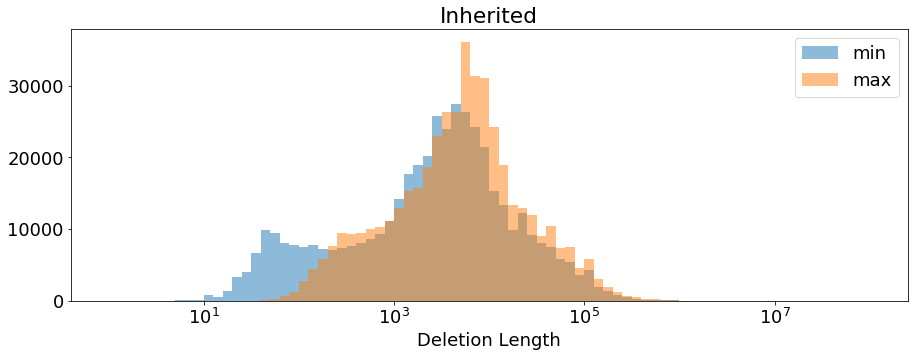

In [14]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

all_lengths = [d['length'] for d in deletions]
#print(np.min(all_lengths), np.max(all_lengths), np.median(all_lengths))
plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), alpha=0.5, label='min')
all_opt_lengths = [d['opt_end_pos']-d['opt_start_pos'] for d in deletions]
plt.hist(np.clip(all_opt_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), alpha=0.5, label='max')
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('Inherited')
plt.legend()

plt.show()

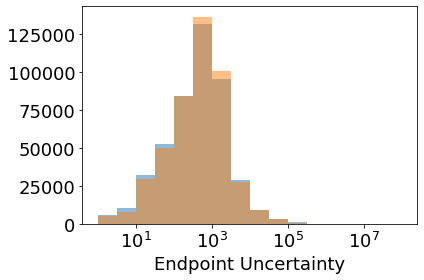

In [15]:
start_uncertainty = [d['start_pos']-d['opt_start_pos'] for d in deletions]
plt.hist(np.clip(start_uncertainty, 1, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.5)), alpha=0.5)
end_uncertainty = [d['opt_end_pos']-d['end_pos'] for d in deletions]
plt.hist(np.clip(end_uncertainty, 1, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.5)), alpha=0.5)

plt.xscale('log')
plt.xlabel('Endpoint Uncertainty')
plt.show()

# QC - check that child order doesn't matter

In [16]:
child_to_index = dict()
for x in deletions:
    if len(x['trans']) == 2:
        if (x['trans'][0], x['family']) in child_to_index:
            assert child_to_index[(x['trans'][0], x['family'])] == 0
        else:
            child_to_index[(x['trans'][0], x['family'])] = 0
        if (x['trans'][1], x['family']) in child_to_index:
            assert child_to_index[(x['trans'][1], x['family'])] == 1
        else:
            child_to_index[(x['trans'][1], x['family'])] = 1
    if len(x['notrans']) == 2:
        if (x['notrans'][0], x['family']) in child_to_index:
            assert child_to_index[(x['notrans'][0], x['family'])] == 0
        else:
            child_to_index[(x['notrans'][0], x['family'])] = 0
        if (x['notrans'][1], x['family']) in child_to_index:
            assert child_to_index[(x['notrans'][1], x['family'])] == 1
        else:
            child_to_index[(x['notrans'][1], x['family'])] = 1        

child1_to_inh_mat_dels = defaultdict(int)
child1_to_inh_pat_dels = defaultdict(int)
child1_to_inh_mat_del_count = defaultdict(int)
child1_to_inh_pat_del_count = defaultdict(int)

child2_to_inh_mat_dels = defaultdict(int)
child2_to_inh_pat_dels = defaultdict(int)
child2_to_inh_mat_del_count = defaultdict(int)
child2_to_inh_pat_del_count = defaultdict(int)

child_to_bothinh_mat_dels = defaultdict(int)
child_to_bothinh_pat_dels = defaultdict(int)
child_to_onlyinh_mat_dels = defaultdict(int)
child_to_onlyinh_pat_dels = defaultdict(int)
child_to_otherinh_mat_dels = defaultdict(int)
child_to_otherinh_pat_dels = defaultdict(int)
child_to_noinh_mat_dels = defaultdict(int)
child_to_noinh_pat_dels = defaultdict(int)

for d in deletions:
    if np.all([(x, d['family']) in child_to_index for x in d['trans']]) and np.all([(x, d['family']) in child_to_index for x in d['notrans']]):
        if d['is_mat']:
            for child in d['trans']:
                if child_to_index[(child, d['family'])]==0:
                    child1_to_inh_mat_dels[(child, d['family'])] += d['length']
                    child1_to_inh_mat_del_count[(child, d['family'])] += 1
                else:
                    child2_to_inh_mat_dels[(child, d['family'])] += d['length']
                    child2_to_inh_mat_del_count[(child, d['family'])] += 1
            
            if len(d['trans'])==0 and len(d['notrans'])==2:
                child_to_noinh_mat_dels[(d['notrans'][0], d['family'])] += d['length']
                child_to_noinh_mat_dels[(d['notrans'][1], d['family'])] += d['length']
            elif len(d['trans'])==1 and len(d['notrans'])==1:
                child_to_onlyinh_mat_dels[(d['trans'][0], d['family'])] += d['length']
                child_to_otherinh_mat_dels[(d['notrans'][0], d['family'])] += d['length']
            elif len(d['trans'])==2 and len(d['notrans'])==0:
                child_to_bothinh_mat_dels[(d['trans'][0], d['family'])] += d['length']
                child_to_bothinh_mat_dels[(d['trans'][1], d['family'])] += d['length']
            
            
        elif d['is_pat']:
            for child in d['trans']:
                if child_to_index[(child, d['family'])]==0:
                    child1_to_inh_pat_dels[(child, d['family'])] += d['length']
                    child1_to_inh_pat_del_count[(child, d['family'])] += 1
                else:
                    child2_to_inh_pat_dels[(child, d['family'])] += d['length']
                    child2_to_inh_pat_del_count[(child, d['family'])] += 1
            
            if len(d['trans'])==0 and len(d['notrans'])==2:
                child_to_noinh_pat_dels[(d['notrans'][0], d['family'])] += d['length']
                child_to_noinh_pat_dels[(d['notrans'][1], d['family'])] += d['length']
            elif len(d['trans'])==1 and len(d['notrans'])==1:
                child_to_onlyinh_pat_dels[(d['trans'][0], d['family'])] += d['length']
                child_to_otherinh_pat_dels[(d['notrans'][0], d['family'])] += d['length']
            elif len(d['trans'])==2 and len(d['notrans'])==0:
                child_to_bothinh_pat_dels[(d['trans'][0], d['family'])] += d['length']
                child_to_bothinh_pat_dels[(d['trans'][1], d['family'])] += d['length']
            

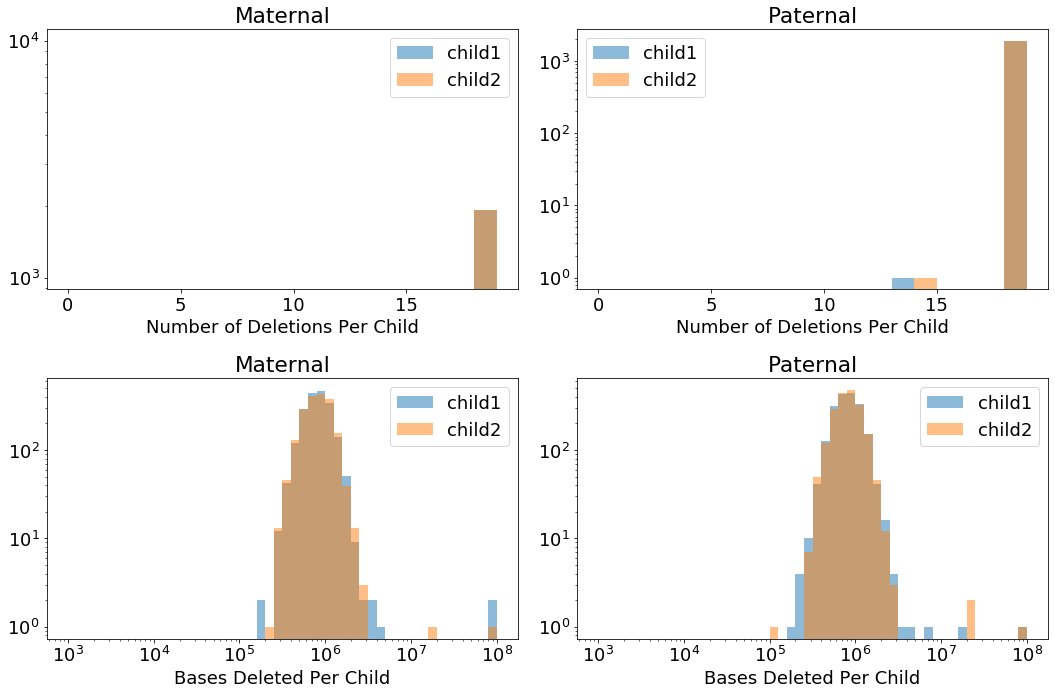

In [17]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.arange(0, 20, 1)

ax = plt.subplot(2, 2, 1)
plt.hist(np.clip(list(child1_to_inh_mat_del_count.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child1')
plt.hist(np.clip(list(child2_to_inh_mat_del_count.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child2')
plt.xlabel('Number of Deletions Per Child')
plt.title('Maternal')
plt.legend()

ax = plt.subplot(2, 2, 2)
plt.hist(np.clip(list(child1_to_inh_pat_del_count.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child1')
plt.hist(np.clip(list(child2_to_inh_pat_del_count.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child2')
plt.xlabel('Number of Deletions Per Child')
plt.title('Paternal')
plt.legend()


bins = np.power(10.0, np.arange(3, 8.1, 0.1))

ax = plt.subplot(2, 2, 3)
plt.hist(np.clip(list(child1_to_inh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child1')
plt.hist(np.clip(list(child2_to_inh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child2')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Maternal')
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
plt.hist(np.clip(list(child1_to_inh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child1')
plt.hist(np.clip(list(child2_to_inh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='child2')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Paternal')
plt.legend()

plt.tight_layout()
plt.show()

# QC - Check transmission probability

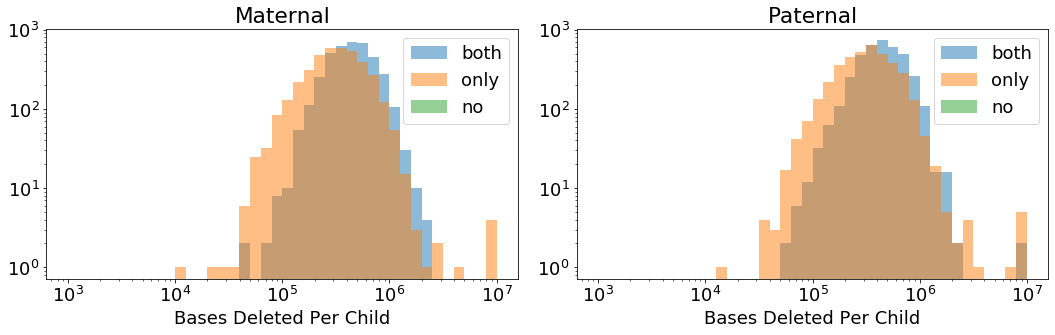

In [19]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

bins = np.arange(0, 701, 10)

bins = np.power(10.0, np.arange(3, 7.1, 0.1))

ax = plt.subplot(1, 2, 1)
plt.hist(np.clip(list(child_to_bothinh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='both')
plt.hist(np.clip(list(child_to_onlyinh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='only')
#plt.hist(np.clip(list(child_to_otherinh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='other')
plt.hist(np.clip(list(child_to_noinh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='no')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Maternal')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
plt.hist(np.clip(list(child_to_bothinh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='both')
plt.hist(np.clip(list(child_to_onlyinh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='only')
#plt.hist(np.clip(list(child_to_otherinh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='other')
plt.hist(np.clip(list(child_to_noinh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='no')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Paternal')
plt.legend()

plt.tight_layout()
plt.show()

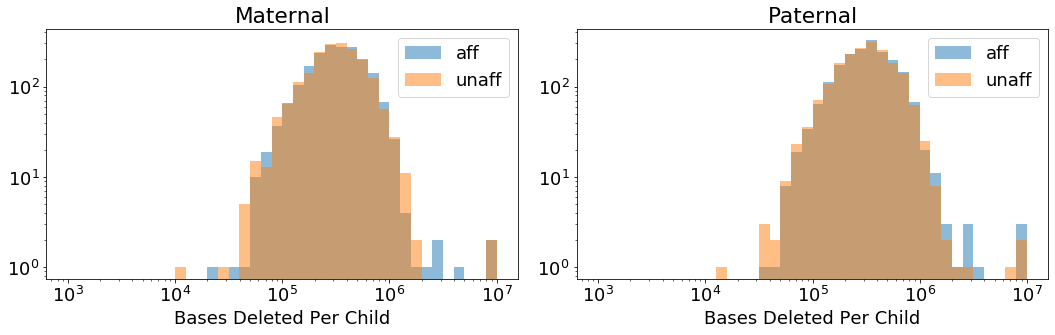

In [18]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

bins = np.arange(0, 701, 10)

bins = np.power(10.0, np.arange(3, 7.1, 0.1))

ax = plt.subplot(1, 2, 1)
plt.hist(np.clip([v for x, v in child_to_onlyinh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_onlyinh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Maternal')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_onlyinh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_onlyinh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Paternal')
plt.legend()

plt.tight_layout()
plt.show()

# Deletions per individual

In [20]:
child_to_inh_mat_dels = defaultdict(int)
child_to_inh_pat_dels = defaultdict(int)
child_to_inh_mat_del_count = defaultdict(int)
child_to_inh_pat_del_count = defaultdict(int)

mom_to_inh_dels = defaultdict(int)
dad_to_inh_dels = defaultdict(int)
mom_to_inh_del_count = defaultdict(int)
dad_to_inh_del_count = defaultdict(int)

mom_to_dels = defaultdict(int)
dad_to_dels = defaultdict(int)
mom_to_del_count = defaultdict(int)
dad_to_del_count = defaultdict(int)


for d in deletions:
    if d['is_mat']:
        for child in d['trans']:
            child_to_inh_mat_dels[(child, d['family'])] += d['length']
            child_to_inh_mat_del_count[(child, d['family'])] += 1
        mom_to_dels[(d['mother'], d['family'])] += d['length']
        mom_to_del_count[(d['mother'], d['family'])] += 1
        if len(d['trans'])>0:
            mom_to_inh_dels[(d['mother'], d['family'])] += d['length']
            mom_to_inh_del_count[(d['mother'], d['family'])] += 1
    elif d['is_pat']:
        for child in d['trans']:
            child_to_inh_pat_dels[(child, d['family'])] += d['length']
            child_to_inh_pat_del_count[(child, d['family'])] += 1
        dad_to_dels[(d['father'], d['family'])] += d['length']
        dad_to_del_count[(d['father'], d['family'])] += 1
        if len(d['trans'])>0:
            dad_to_inh_dels[(d['father'], d['family'])] += d['length']
            dad_to_inh_del_count[(d['father'], d['family'])] += 1


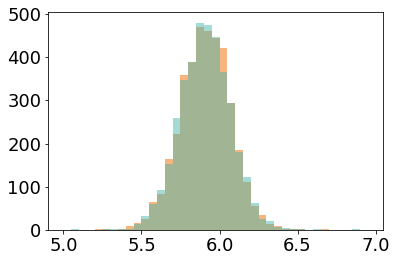

In [28]:
children = sorted(set([x[0] for x in child_to_inh_mat_dels.keys()] + [x[0] for x in child_to_inh_pat_dels.keys()]))
child_to_keys = defaultdict(list)
for key in child_to_inh_mat_dels.keys():
    child_to_keys[key[0]].append(key)
    
mat_dels = np.array([np.median([child_to_inh_mat_dels[key] for key in child_to_keys[child]]) for child in children])
pat_dels = np.array([np.median([child_to_inh_pat_dels[key] for key in child_to_keys[child]]) for child in children])

plt.hist(np.log10(mat_dels), alpha=0.5, bins=np.arange(5, 7, 0.05), color=colors[0])
plt.hist(np.log10(pat_dels), alpha=0.5, bins=np.arange(5, 7, 0.05), color=colors[1])
plt.show()

Ttest_indResult(statistic=0.09351146489261476, pvalue=0.9255021127771178)
Ttest_indResult(statistic=0.472840823188139, pvalue=0.636353578559489)
Ttest_indResult(statistic=-0.02997739614255005, pvalue=0.976086635745024)
Ttest_indResult(statistic=0.3892370165717143, pvalue=0.6971223724537071)
Ttest_indResult(statistic=0.369676802433578, pvalue=0.711643671410457)
Ttest_indResult(statistic=0.7869550659780483, pvalue=0.4313566598042238)


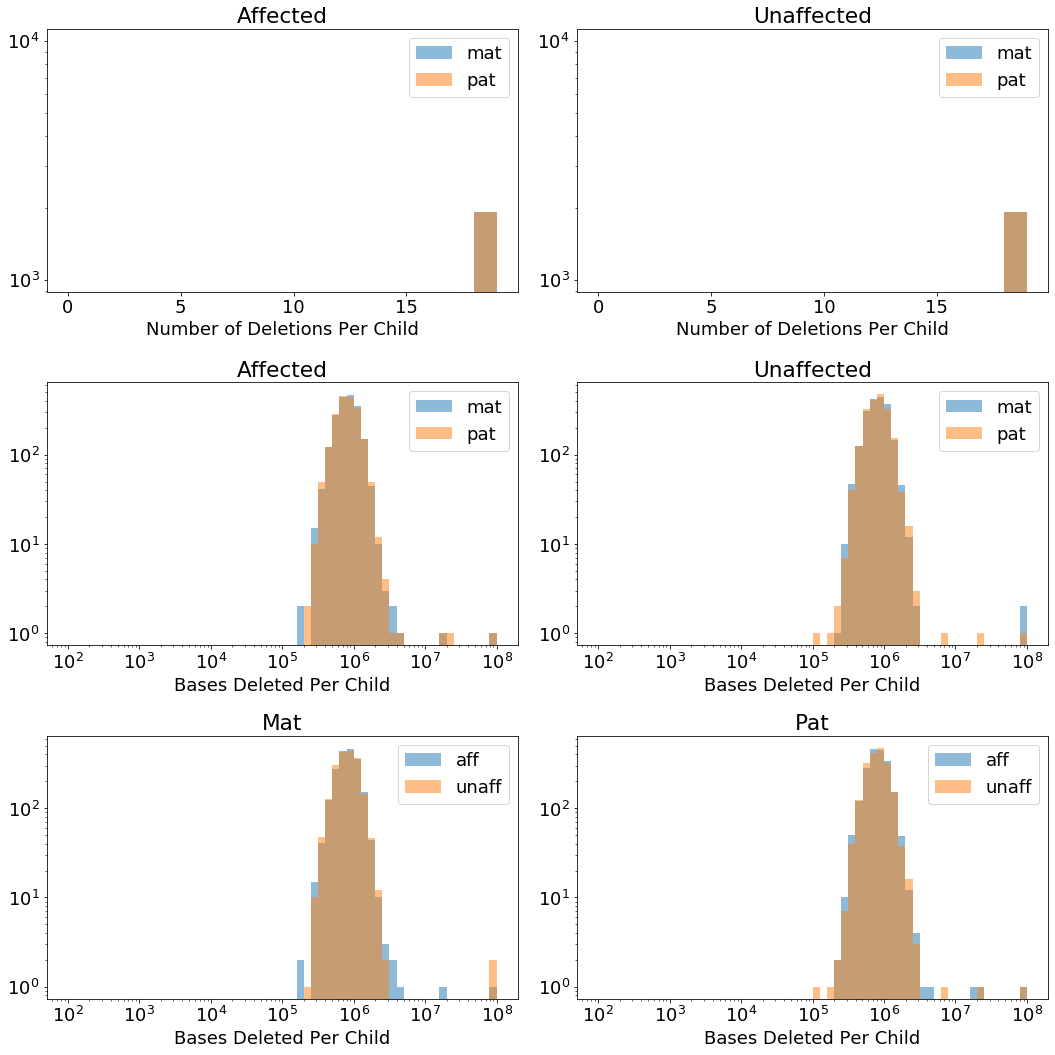

In [21]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 15))

bins = np.arange(0, 20, 1)

ax = plt.subplot(3, 2, 1)
plt.hist(np.clip([v for x, v in child_to_inh_mat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip([v for x, v in child_to_inh_pat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xlabel('Number of Deletions Per Child')
plt.title('Affected')
plt.legend()

print(stats.ttest_ind([v for x, v in child_to_inh_mat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'],
                     [v for x, v in child_to_inh_pat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2']))

plt.subplot(3, 2, 2, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_inh_mat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip([v for x, v in child_to_inh_pat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xlabel('Number of Deletions Per Child')
plt.title('Unaffected')
plt.legend()

print(stats.ttest_ind([v for x, v in child_to_inh_mat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'],
                     [v for x, v in child_to_inh_pat_del_count.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1']))


bins = np.power(10.0, np.arange(2, 8.1, 0.1))

ax = plt.subplot(3, 2, 3)
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Affected')
plt.legend()

print(stats.ttest_ind(np.log10([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2']),
                     np.log10([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'])))


plt.subplot(3, 2, 4, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Unaffected')
plt.legend()

print(stats.ttest_ind(np.log10([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1']),
                     np.log10([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'])))


ax = plt.subplot(3, 2, 5)
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Mat')
plt.legend()

print(stats.ttest_ind(np.log10([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2']),
                     np.log10([v for x, v in child_to_inh_mat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'])))


plt.subplot(3, 2, 6, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Child')
plt.title('Pat')
plt.legend()

print(stats.ttest_ind(np.log10([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '2']),
                     np.log10([v for x, v in child_to_inh_pat_dels.items() if x[0] in child_id_to_affected and child_id_to_affected[x[0]] == '1'])))



plt.tight_layout()
plt.show()

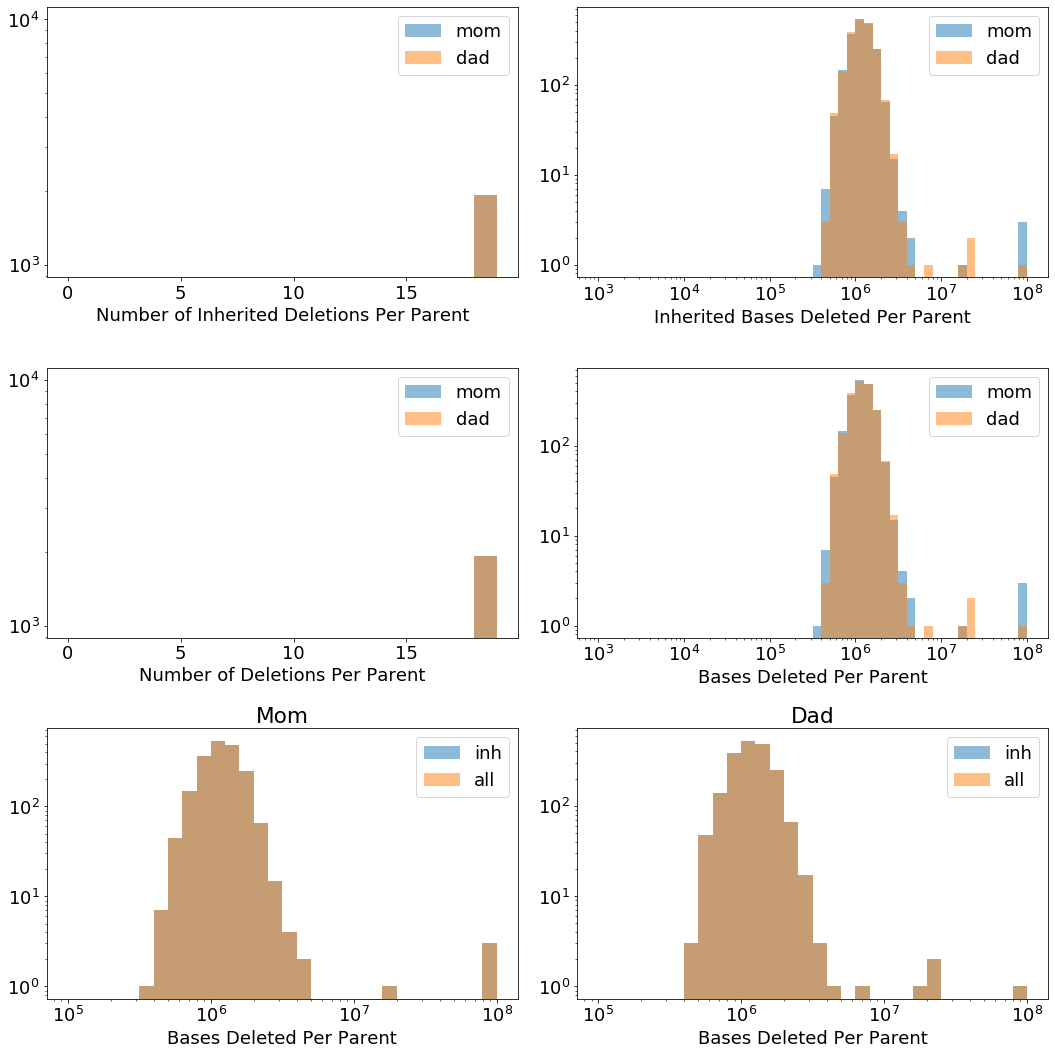

In [22]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 15))

bins = np.arange(0, 20, 1)

ax = plt.subplot(3, 2, 1)
plt.hist(np.clip([v for x, v in mom_to_inh_del_count.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mom')
plt.hist(np.clip([v for x, v in dad_to_inh_del_count.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dad')
plt.xlabel('Number of Inherited Deletions Per Parent')
plt.legend()

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

ax = plt.subplot(3, 2, 2)
plt.hist(np.clip([v for x, v in mom_to_inh_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mom')
plt.hist(np.clip([v for x, v in dad_to_inh_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dad')
plt.xscale('log')
plt.xlabel('Inherited Bases Deleted Per Parent')
plt.legend()

bins = np.arange(0, 20, 1)

ax = plt.subplot(3, 2, 3)
plt.hist(np.clip([v for x, v in mom_to_del_count.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mom')
plt.hist(np.clip([v for x, v in dad_to_del_count.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dad')
plt.xlabel('Number of Deletions Per Parent')
plt.legend()

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

ax = plt.subplot(3, 2, 4)
plt.hist(np.clip([v for x, v in mom_to_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mom')
plt.hist(np.clip([v for x, v in dad_to_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dad')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Parent')
plt.legend()

bins = np.power(10.0, np.arange(5, 8.1, 0.1))

ax = plt.subplot(3, 2, 5)
plt.hist(np.clip([v for x, v in mom_to_inh_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='inh')
plt.hist(np.clip([v for x, v in mom_to_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='all')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Parent')
plt.title('Mom')
plt.legend()

ax = plt.subplot(3, 2, 6)
plt.hist(np.clip([v for x, v in dad_to_inh_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='inh')
plt.hist(np.clip([v for x, v in dad_to_dels.items()], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='all')
plt.xscale('log')
plt.xlabel('Bases Deleted Per Parent')
plt.title('Dad')
plt.legend()


plt.tight_layout()
plt.show()